# Analysis of the Financial Loan Data

The ultimate goal for this analysis is to provide deeper insights into the Financial Loans Dataset so the company can make informed decisions about which loans are higher risk. This will involve looking at previous loans that have not been paid back in full, looking at the loss in revenue for the company from these loans and providing possible indicators why the loans were not paid back in full. This will give the company a better understanding of who they can provide loans to without such risk being involved. 

## Necessary Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Loading in transformed Dataset

In [2]:
transformed_financial_loan_df = pd.read_csv('transformed_financial_loan_data.csv')

## Adding a New Column

Before starting the analysis of the Financial Loans Dataset, I am going to create a new column called 'total_paid_if_loan_completed'. This column will give a figure for each row which represents the total amount of money that would have been paid back if the loan was completed.

For this, the 'term' column will have to be converted from the dtype 'category' to the dtype 'int64'. The 'term' column was originally 'category' as their were only 2 options for a value to be, but for this analysis we need the column as an integer.

In [3]:
transformed_financial_loan_df['term'] = transformed_financial_loan_df['term'].str.extract(r'(\d+)').astype('int64')

In [4]:
transformed_financial_loan_df['total_paid_if_loan_completed'] = transformed_financial_loan_df['instalment'] * transformed_financial_loan_df['term']

## Current state of the Loans

There are two things I want to do to check the current state of the loans:
 
the first is to summarise what percentage of the loans have been currently recovered compared to the total amount to be paid over the loans term including interest.
The second is to calculate how much will be paid back in 6 months time with interest.

For both of these I will create visualisations so the results are easier to visualise and analyse.

### Recovery Percentage of Loans

To do this, I will take the 'total_payment' column and divide it by the 'total_paid_if_loan_completed' column (multiplied by 100) to calculate the percentage of the loan recovered and provide the results in the 'recovery_percentage' column. I will visualise the results in a histogram plot.

In [5]:
transformed_financial_loan_df['recovery_percentage'] = (transformed_financial_loan_df['total_payment'] / transformed_financial_loan_df['total_paid_if_loan_completed']) * 100

print(transformed_financial_loan_df['recovery_percentage'].describe())

count    54231.000000
mean        75.617753
std         26.018343
min          0.000000
25%         66.643426
50%         81.596935
75%         96.975276
max        168.062642
Name: recovery_percentage, dtype: float64


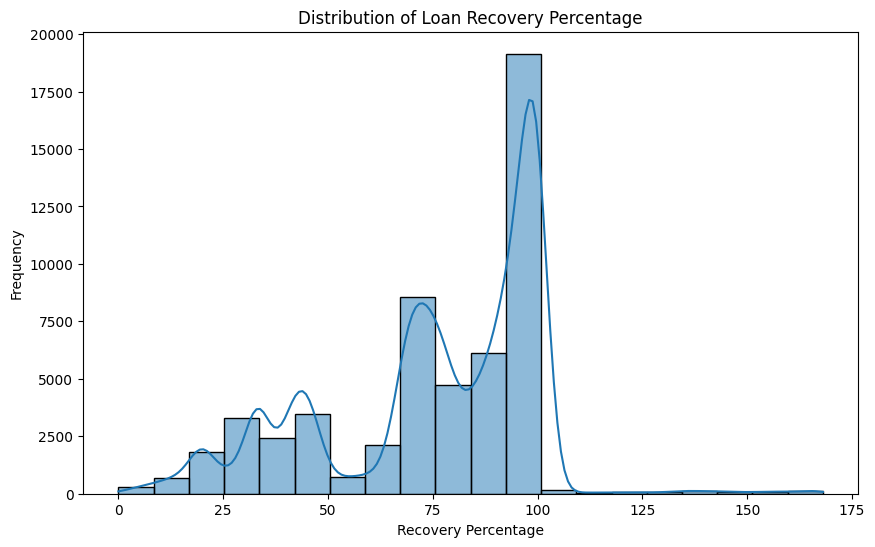

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(transformed_financial_loan_df['recovery_percentage'], kde=True, bins=20)
plt.title('Distribution of Loan Recovery Percentage')
plt.xlabel('Recovery Percentage')
plt.ylabel('Frequency')
plt.show()

#### Insights
- The most common recovery percentage frequency is around 90% to 100% suggesting a lot of the loans have been fully recovered or are close to being fully recovered.
- The peak around 75% may suggest borrowers are struggling to make payments on their loans but are still trying to pay them back. 
- The recovery percentages exceeding 100% are due to the late fees added to a borrowers loan if their payments are not made on time. 

To have a better understanding of why their are peaks arising near 75% recovery percentage and lower, a more in depth analysis should be executed where other factors such as the loan grades should be taken into consideration. Also a look into 'payment_plan' should be considered to check if the lower percentage recovery has a correlation to whether someone is on a payment plan as this would give further indication the borrower is struggling to make payments. We will explore this further later in the analysis.

### Payments for the next 6 months

In [7]:
transformed_financial_loan_df['total_paid_6mths'] = transformed_financial_loan_df['instalment'] * 6

In [8]:
total_payments_for_6mths = transformed_financial_loan_df['total_paid_6mths'].sum()
print(f'The total payments for the next 6 months will be: £{round(total_payments_for_6mths, 2)}')

The total payments for the next 6 months will be: £130158940.26


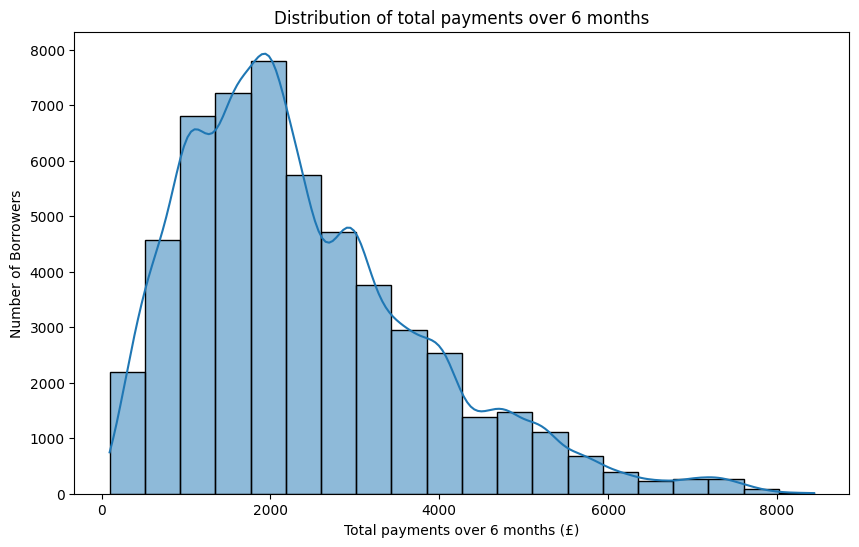

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(transformed_financial_loan_df['total_paid_6mths'], kde=True, bins=20)
plt.title('Distribution of total payments over 6 months')
plt.xlabel('Total payments over 6 months (£)')
plt.ylabel('Number of Borrowers')
plt.show()

#### Insights
- The plot shows a right-skew, indicating most loans are of a lower price
- Highest frequency of loan return in 6 months is around the £2,000 mark; gives a key area to look at when focusing on which loans are the most popular in terms of instalments
- Most of the loans are of a moderate size, less common for loans to be over £6,000 in a 6 month period

## Calculating percentage loss 

I will calculate what percentage of loans that have been a loss to the company and calculate the total amount that was paid towards these loans before being charged off.

From finding the unique values in the 'loan_status' column, I can see their are two ways Charged Off values are represented, I will combine these to give a better analysis of the percentage of loans Charged Off.
From this: 
- I compare the length of how many values this represents compared to the total number of loans to calculate the percentage of Charged Off loans.
- I sum the 'total_payment' column for the Charged Off loans to see the total amount paid for the loans before they were classed as Charged Off.

In [10]:
transformed_financial_loan_df['loan_status'].value_counts()

loan_status
Fully Paid                                             27037
Current                                                19268
Charged Off                                             5571
Does not meet the credit policy. Status:Fully Paid       984
Late (31-120 days)                                       580
Does not meet the credit policy. Status:Charged Off      368
In Grace Period                                          265
Late (16-30 days)                                        106
Default                                                   52
Name: count, dtype: int64

In [11]:
charged_off_loans = transformed_financial_loan_df[(transformed_financial_loan_df['loan_status'] == 'Charged Off') | 
                                                  (transformed_financial_loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off')
                                                  ].copy()

In [12]:
percentage_charged_off = (len(charged_off_loans) / len(transformed_financial_loan_df)) * 100
print(f'The percentage of Charged Off loans is: {round(percentage_charged_off, 2)}%')

The percentage of Charged Off loans is: 10.95%


In [13]:
total_amount_charged_off_loans = charged_off_loans['total_payment'].sum()
print(f'The total amount paid towards these loans before being Charged Off is: £{round(total_amount_charged_off_loans, 2)}')

The total amount paid towards these loans before being Charged Off is: £39247128.38


#### Insights and Results

The percentage of Charged Off loans is: **10.95%**

The total amount paid towards these loans before being Charged Off is: **£39,247,128.38**

This gives an indication that for the loans the company provides, roughly 10% of these will not be completed equating in a loss of revenue. From the 10.95% of loans classed as Charged Off, £39247128.38 was able to be received to the company preventing further loss in revenue. I will now explore further analysis into revenue loss with the loans in the dataset and then analyse how we can identify a future risky loan to help with prevention of Charged Off loans.

## Calculating projected revenue loss 

I will calculate the expected loss of the loans marked as Charged Off. I will then calculate the total revenue loss from the Charged Off loans to see how much the company is losing with these loans and visualise the loss projected over the remaining term of these loans.

In [49]:
charged_off_loans['expected_loss'] = charged_off_loans['total_paid_if_loan_completed'] - charged_off_loans['total_payment']
charged_off_loans['expected_loss'] = charged_off_loans['expected_loss'].clip(lower=0.1)

In [50]:
revenue_loss = charged_off_loans['expected_loss'].sum()
print(f' The total revenue loss for the company from Charged Off loans is: £{round(revenue_loss, 2)}')

 The total revenue loss for the company from Charged Off loans is: £67420215.03


In [51]:
charged_off_loans['term_remaining'] = charged_off_loans['term'] - (charged_off_loans['total_payment'] / charged_off_loans['instalment'])
charged_off_loans['term_remaining'] = charged_off_loans['term_remaining'].clip(lower=1)

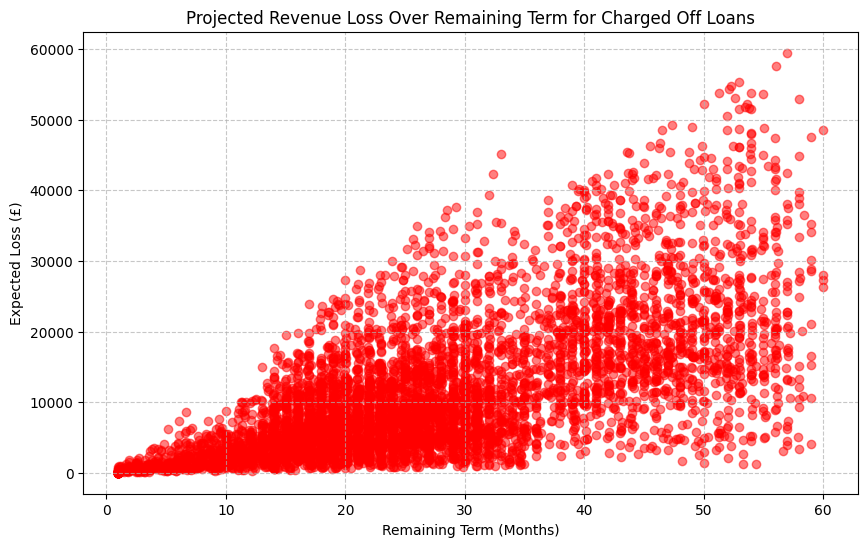

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(charged_off_loans['term_remaining'], charged_off_loans['expected_loss'], alpha=0.5, color='red')
plt.title('Projected Revenue Loss Over Remaining Term for Charged Off Loans')
plt.xlabel('Remaining Term (Months)')
plt.ylabel('Expected Loss (£)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

The total revenue loss for the company from Charged Off loans is: **£67,420,215.03**. This is a significant amount from the Charged Off loans and so I will analyse any indications within the dataset columns as to why these loans have not been paid back in full. 

#### Projected Revenue Loss Over Remaining Term for Charged Off Loans insights
- The graph shows the projected revenue loss increases as the remaining term in months increases, showing loans with longer remaining terms represent higher potential losses, as the unpaid instalments over a longer period accumulate.
- The majority of loans show lower expected loses, under £15,000. The less term remaining, the less revenue lost per loan. This is due to most of the loan being paid back when the term remaining is low.
- Some loans with terms between 50 - 60 months have extremely high losses, exceeding £50,000. These would indicate customers who have defaulted early in their terms and so are a high risk loan.

## Calculating further possible revenue loss

I will now explore the customers who are currently behind with their loan payments as these present risk to the companys revenue. To do this I will calculate the percentage and number of customers this represents, calculate how much loss the company would incur if their status was changed to Charged Off and finally what the total percentage of Charged Off loans would be if these late loans are changed to Charged Off. 

This will give a more quantative analysis in regards to revenue loss and assessing the amount of risky loans the company currently has. The results from this analysis will then be used to find indicators within the data to show which loans are more likely to be risky before a loan is approved. 

In [77]:
possible_loss_df = transformed_financial_loan_df[(transformed_financial_loan_df['loan_status'] == 'Late (16-30 days)') |
                                              (transformed_financial_loan_df['loan_status'] == 'Late (31-120 days)') |
                                              (transformed_financial_loan_df['loan_status'] == 'In Grace Period')
                                            ].copy()

In [79]:
possible_loss_percentage_of_loans = (len(possible_loss_df) / len(transformed_financial_loan_df)) * 100
print(f'The percentage of loans that could result in further revenue loss is: {round(possible_loss_percentage_of_loans, 2)}%')

The percentage of loans that could result in further revenue loss is: 1.75%


In [81]:
print(f'Total number of customer loans that are considered a risk: {len(possible_loss_df)} customer loans')

Total number of customers that are considered a risk: 951 customers


In [94]:
possible_loss_df['expected_loss_if_charged_off'] = possible_loss_df['total_paid_if_loan_completed'] - possible_loss_df['total_payment']
loss_in_revenue_if_charged_off = possible_loss_df['expected_loss_if_charged_off'].sum()
print(f'The total loss to the company if these loans are changed to Charged Off is: £{round(loss_in_revenue_if_charged_off, 2)}')

The total loss to the company if these loans are changed to Charged Off is: £9563078.8


In [104]:
if_loans_complete = possible_loss_df['total_paid_if_loan_completed'].sum()
print(f'If these loans that are late are completed, the total revenue from these will be: £{round(if_loans_complete, 2)}')

If these loans that are late are completed, the total revenue from these will be: £19704190.8


In [127]:
default_loss_loans = transformed_financial_loan_df[(transformed_financial_loan_df['loan_status'] == 'Default')].copy()

default_loss_loans['expected_loss'] = default_loss_loans['total_paid_if_loan_completed'] - default_loss_loans['total_payment']
default_revenue_loss = default_loss_loans['expected_loss'].sum()

In [ ]:
total_expected_revenue = transformed_financial_loan_df['total_paid_if_loan_completed'].sum()

In [132]:
total_revenue_loss = revenue_loss + loss_in_revenue_if_charged_off + default_revenue_loss
percentage_loss_overall = (total_revenue_loss / total_expected_revenue) * 100

print(f'The total percentage revenue loss for the company would be: {round(percentage_loss_overall, 2)}%')

The total percentage revenue loss for the company would be: 8.36%


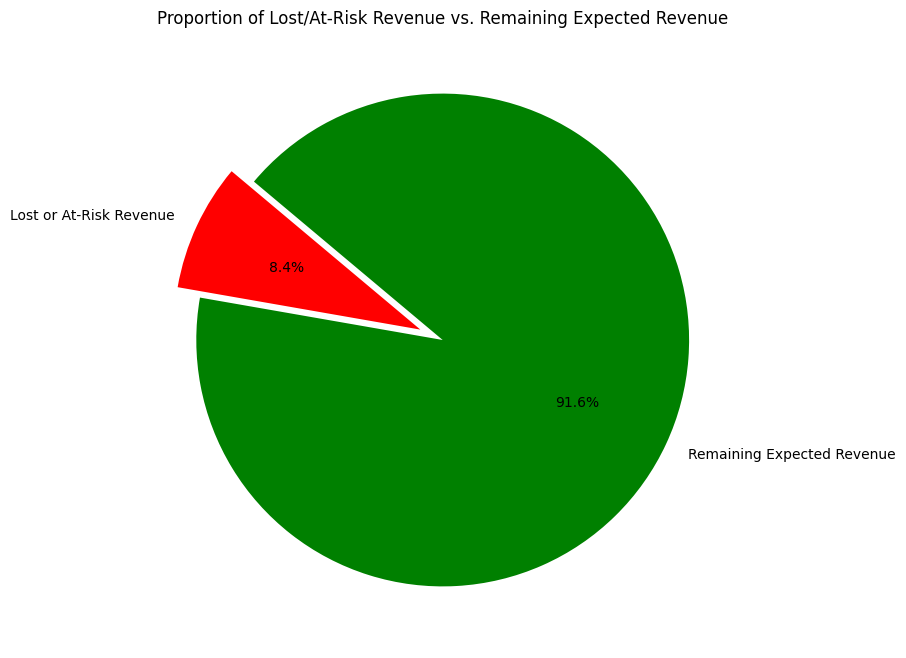

In [136]:
remaining_revenue = total_expected_revenue - total_revenue_loss

labels = ['Lost or At-Risk Revenue', 'Remaining Expected Revenue']
sizes = [total_revenue_loss, remaining_revenue]
colours = ['red', 'green']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colours, autopct='%1.1f%%', startangle=140, explode=(0.1, 0)) 
plt.title('Proportion of Lost/At-Risk Revenue vs. Remaining Expected Revenue')
plt.show()

### Insights
The percentage of loans that could result in further revenue loss is: **1.75%**. These loans are either Late or in a Grace Period meaning they are at risk of being Charged Off and resulting in revenue loss for the company.

The total number of customer loans that are considered a risk: **951 customer loans**. 951 loans currently qualify as a risk and so could end up being a loss to the companys revenue.

The total loss to the company if these loans are changed to Charged Off is: **£9,563,078.80**. If all 951 customer loans are changed to Charged Off, the company will loose £9.5 million in revenue.

If these loans that are late are completed, the total revenue from these will be: **£19,704,190.80**. If the loans do get completed, the company will receive 19.7 million total from these loans.

The total percentage revenue loss for the company would be: **8.36%**. This means if all the late loans are chaned to Charged Off and combined with the already Charged Off loans, the company would be at a 8.36% revenue loss. 

## Indicators of why loans are not paid back

I will analyse the data to visualise the possible indicators that a customer will not be able to pay the loan. This will entail comparing columns which might be indicators against customers who have already stopped paying and customers who are currently behind on payments.

The columns in the Financial Loans dataset i will focus on are:
- grade
- purpose
- home_ownership

These columns will be analysed to see if they could be possible indicators as to whether someone will not finish their loan payments. From this I would be able to have a better understanding of which loans will be considered risky so the company does not invest in these loans and ultimately does not lose revenue. 

In [15]:
charged_off_customers = transformed_financial_loan_df[(transformed_financial_loan_df['loan_status'] == 'Charged Off') | 
                                                  (transformed_financial_loan_df['loan_status'] == 'Does not meet the credit policy. Status:Charged Off')
                                                  ].copy()

risk_customers = transformed_financial_loan_df[(transformed_financial_loan_df['loan_status'] == 'Late (16-30 days)') |
                                              (transformed_financial_loan_df['loan_status'] == 'Late (31-120 days)') |
                                              (transformed_financial_loan_df['loan_status'] == 'In Grace Period')
                                            ].copy()

#### Grade of loan

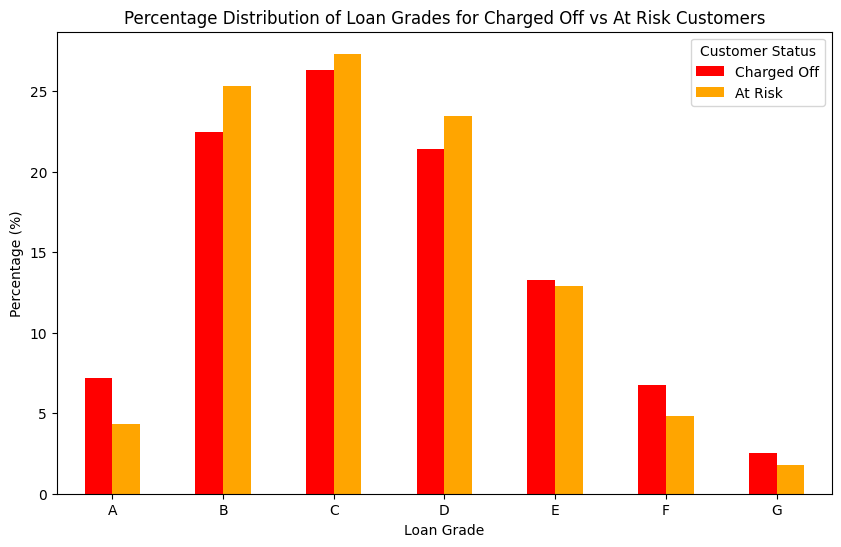

In [22]:
grade_comparison = pd.DataFrame({
    'Charged Off': charged_off_customers['grade'].value_counts(),
    'At Risk': risk_customers['grade'].value_counts()
}).fillna(0)

grade_comparison_percentage = grade_comparison.div(grade_comparison.sum(axis=0), axis=1) * 100

grade_comparison_percentage.plot(kind='bar', figsize=(10, 6), color=['red', 'orange'])
plt.title('Percentage Distribution of Loan Grades for Charged Off vs At Risk Customers')
plt.xlabel('Loan Grade')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Customer Status')
plt.show()

From this visualisation we can see the Charged Off loans and the Loans at risk have a high correlation in terms of proportion of percentages. This would suggest grade C and B are indicators for a customer to less likely pay back their loan. However, I will now compare these two types of loans against all loans to see if the high proportion of loans C and B are just because the overall loans count tend towards these being the most popular loans.

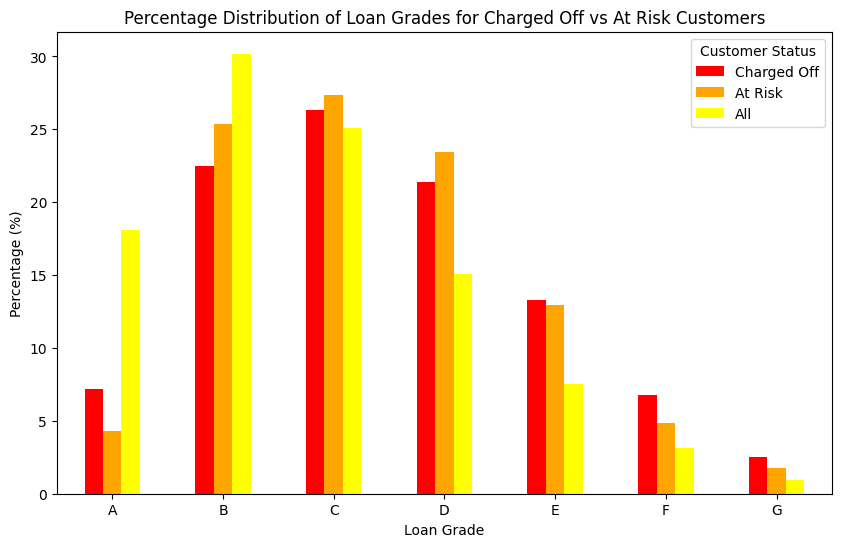

In [35]:
grade_comparison_all = pd.DataFrame({
    'Charged Off': charged_off_customers['grade'].value_counts(),
    'At Risk': risk_customers['grade'].value_counts(),
    'All': transformed_financial_loan_df['grade'].value_counts()
}).fillna(0)

grade_comparison_percentage = grade_comparison_all.div(grade_comparison_all.sum(axis=0), axis=1) * 100

grade_comparison_percentage.plot(kind='bar', figsize=(10, 6), color=['red', 'orange', 'yellow'])
plt.title('Percentage Distribution of Loan Grades for Charged Off vs At Risk vs All Customers')
plt.xlabel('Loan Grade')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Customer Status')
plt.show()

From first glance at the initial bar plot showing the Percentage Distribution of Loan Grades for Charged Off vs At Risk Customers, you may suspect that Loan Grades C and B present the biggest risk to the company as these loans contain the highest percentage of loans that are Charged Off and at risk. However, when comparing all loans compared to the Charged Off and risky loans, we see a different story. As grade loans C and B are the most popular loans overall of course they will have a greater count, but in fact grade B loans are below the overall proportion percentage for both charged off and at risk loans suggesting grade B loans are less likely to be Charged off or at risk. From the graph we can see loans D and E have a much higher percentage proportion of being charged off or at risk compared to the overall loan proportion percentage. This suggest customers with grades D, E, F and G are more likely to not pay back their loan in full. A grade C loan also suggests this but to a lesser extent.

Grade A loans show the opposite and suggest someone with a grade A loan is more likely to pay back their loan in full.

#### Purpose for loan

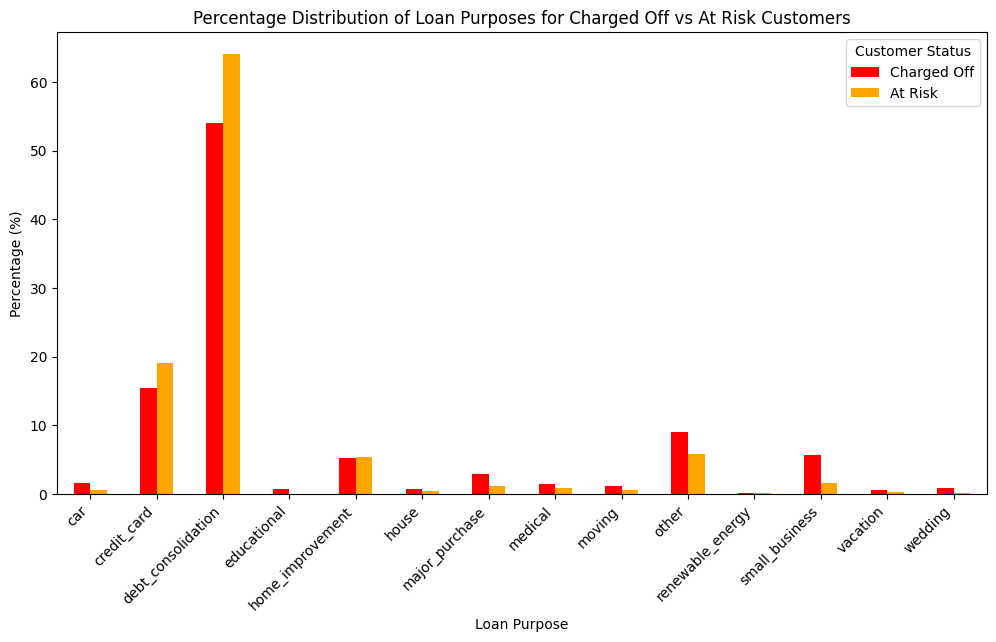

In [28]:
purpose_comparison = pd.DataFrame({
    'Charged Off': charged_off_customers['purpose'].value_counts(),
    'At Risk': risk_customers['purpose'].value_counts()
}).fillna(0)

purpose_comparison_percentage = purpose_comparison.div(purpose_comparison.sum(axis=0), axis=1) * 100

purpose_comparison_percentage.plot(kind='bar', figsize=(12, 6), color=['red', 'orange'])
plt.title('Percentage Distribution of Loan Purposes for Charged Off vs At Risk Customers')
plt.xlabel('Loan Purpose')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Status')
plt.show()

Over 50% of charged off loans and 60% of at-risk loans are for debt consolidation. Debt consolidation loans appear to carry higher risk, possibly due to the nature of borrowers seeking such loans (likely struggling with other debts already). 

The second-highest loan purpose is credit card.
A significant portion of both charged-off and at-risk loans (around 20%) are related to credit card debts.
Borrowers seeking credit card refinancing may also represent a financially stressed group.

The trends observed in charged-off customers are similar to those in the at-risk group, suggesting these purposes may indeed be reliable predictors of future charge-offs.

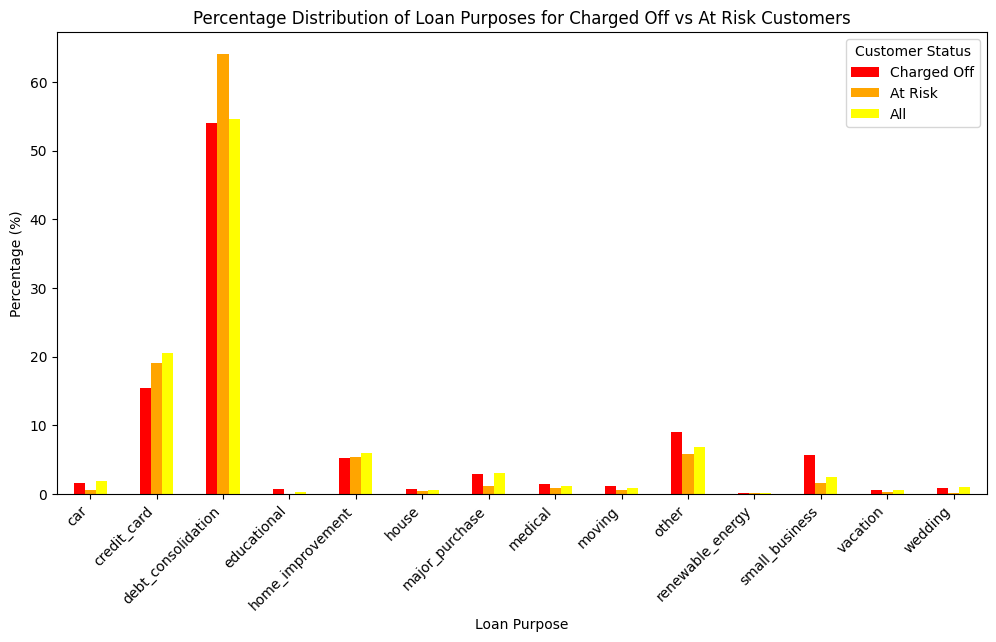

In [37]:
purpose_comparison_all = pd.DataFrame({
    'Charged Off': charged_off_customers['purpose'].value_counts(),
    'At Risk': risk_customers['purpose'].value_counts(),
    'All': transformed_financial_loan_df['purpose'].value_counts()
}).fillna(0)

purpose_comparison_percentage = purpose_comparison_all.div(purpose_comparison_all.sum(axis=0), axis=1) * 100

purpose_comparison_percentage.plot(kind='bar', figsize=(12, 6), color=['red', 'orange', 'yellow'])
plt.title('Percentage Distribution of Loan Purposes for Charged Off vs At Risk Customers')
plt.xlabel('Loan Purpose')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Customer Status')
plt.show()

Educational loans and small business loans are overrepresented in the Charged Off group, suggesting that these loans directly correlate with default.
Their absence in the At Risk group indicates that they don't typically fall into the "at risk" category first but go straight into default, likely due to factors such as low repayment ability or high financial stress associated with these loans.

Comparing the All customers percentage with Charged Off and At Risk groups shows that the trends for risky loans align closely with the overall dataset but with notable amplifications in key categories like debt consolidation.

For loans like educational loans and small business loans, there might be fewer opportunities to intervene before default.
For loans like debt consolidation or credit card refinancing, intervention strategies could be more effective, as these loans spend time in the At Risk category before defaulting.

#### Home ownership

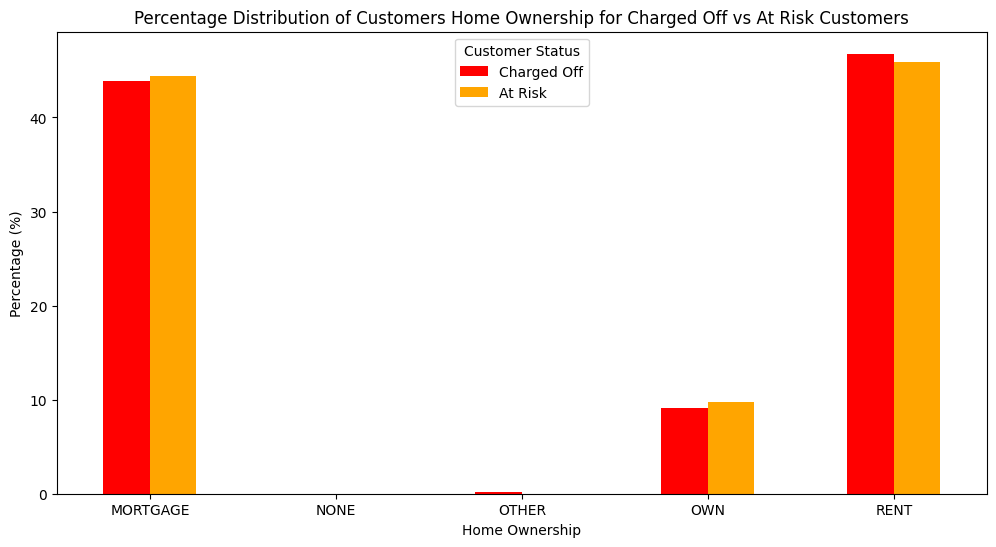

In [47]:
home_ownership_comparison = pd.DataFrame({
    'Charged Off': charged_off_customers['home_ownership'].value_counts(),
    'At Risk': risk_customers['home_ownership'].value_counts()
}).fillna(0)

home_ownership_comparison_percentage = home_ownership_comparison.div(home_ownership_comparison.sum(axis=0), axis=1) * 100

home_ownership_comparison_percentage.plot(kind='bar', figsize=(12, 6), color=['red', 'orange'])
plt.title('Percentage Distribution of Customers Home Ownership for Charged Off vs At Risk Customers')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Customer Status', loc='upper center')
plt.show()

Customers who have a mortgage or are renting constitute the majority of both Charged Off and At Risk loans.
Approximately 43% of customers in each category have a mortgage, and 46% rent their home.

Approximately 10% of customers in each category own their home outright. The similarity between Charged Off and At Risk proportions suggests that owning a home may not significantly protect borrowers from financial instability.

The NONE and OTHER categories are effectively negligible or nonexistent in the dataset, showing minimal to no impact.

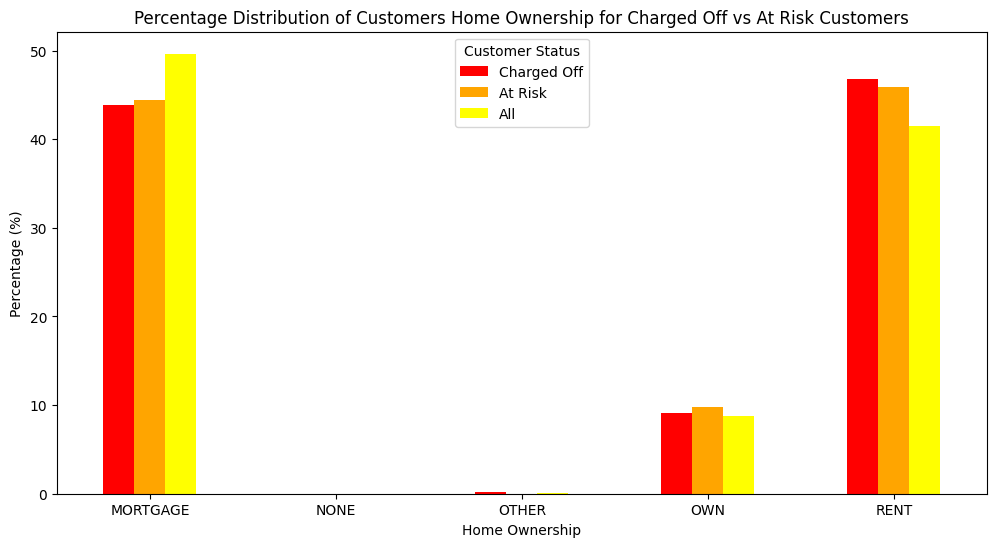

In [48]:
home_ownership_comparison_all = pd.DataFrame({
    'Charged Off': charged_off_customers['home_ownership'].value_counts(),
    'At Risk': risk_customers['home_ownership'].value_counts(),
    'All': transformed_financial_loan_df['home_ownership'].value_counts()
}).fillna(0)

home_ownership_comparison_percentage = home_ownership_comparison_all.div(home_ownership_comparison_all.sum(axis=0), axis=1) * 100

home_ownership_comparison_percentage.plot(kind='bar', figsize=(12, 6), color=['red', 'orange', 'yellow'])
plt.title('Percentage Distribution of Customers Home Ownership for Charged Off vs At Risk Customers')
plt.xlabel('Home Ownership')
plt.ylabel('Percentage (%)')
plt.xticks(rotation=0)
plt.legend(title='Customer Status', loc='upper center')
plt.show()

The All category shows that 50% of all customers in the dataset have a mortgage.
For both Charged Off and At Risk customers, the percentage is slightly lower at 43%.
This suggests that while having a mortgage is common across all loans, it doesn't seem to be a significant factor distinguishing loans that are in trouble (Charged Off or At Risk) from the general dataset.

For customers who own their homes outright, the percentage is steady at roughly 10% across all three categories (Charged Off, At Risk, and All).
This consistency indicates that owning a home outright doesn’t appear to correlate strongly with whether a loan is performing or at risk of default.

Renters make up 46% of both Charged Off and At Risk loans but drop slightly to 40% in the All category.
This suggests that renting may be slightly overrepresented in loans that are struggling or in default compared to the overall dataset.
Renters could potentially be a group to focus on when evaluating financial risk, as they might have less financial stability compared to mortgage holders or homeowners.

## Future steps to mitigate revenue loss

#### Implement Risk-Based Pricing
Loan grades and purposes are strong indicators of financial risk. For example, loans for educational purposes and renters show a higher likelihood of being charged off.

Action: Adjust interest rates or loan terms based on risk levels.
Charge higher interest rates for high-risk loan purposes like "educational" or "small business."
Require larger down payments or collateral for riskier customers.

Impact: This helps compensate for the risk and reduces potential revenue loss.

### Enhanced Risk Assessment at Origination
Characteristics such as renters, lower-grade loans, and certain loan purposes are correlated with a higher risk of default.

Action: Refine credit scoring models to include key factors like loan purpose, homeownership, and debt-to-income ratio.
Use predictive analytics to assess the likelihood of loan defaults more accurately.
Reject or offer alternative products to high-risk applicants.

Impact: This reduces the number of non-performing loans from the outset.

### Continuous Data Analysis and Machine Learning
Patterns in loan defaults may evolve over time.

Action: Regularly update and retrain predictive models using new data to improve risk assessment accuracy.
Use clustering techniques to identify emerging customer risk profiles.
Monitor and compare cohorts of customers by homeownership, loan purpose, and grades.

Impact: Staying ahead of trends ensures that risk strategies remain effective.